In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


In [2]:
!pip install flaml

     |████████████████████████████████| 143 kB 614 kB/s            
     |████████████████████████████████| 24.8 MB 564 kB/s            
     |████████████████████████████████| 157.5 MB 65 kB/s              
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.2
    Uninstalling xgboost-1.5.2:
      Successfully uninstalled xgboost-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 

In [3]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from flaml import AutoML
import optuna
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [4]:
# read csv files
gen = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=';', decimal=',')
temp = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=';', decimal=',')

In [5]:
len(gen), len(temp)

(26304, 26399)

In [6]:
# slicing frames due to deficiencies in data
df = pd.concat([gen.drop('DateTime', axis=1), temp], axis=1)
df.drop(df.index[26304:], axis=0, inplace=True)
#df = pd.concat([gen.iloc[:25560], temp.iloc[:25560].drop('DateTime', axis=1)], axis=1)
df.head(5)

,Generation,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,0.00000000,01Jan2019 0:00:00,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,10.00000000,6.30000000
1,0.00000000,01Jan2019 1:00:00,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,10.00000000,4.50000000
2,0.00000800,01Jan2019 2:00:00,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,10.00000000,5.50000000
3,0.00000000,01Jan2019 3:00:00,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,10.00000000,7.60000000
4,0.00000800,01Jan2019 4:00:00,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,10.00000000,6.50000000


In [7]:
df.dtypes

Generation             float64
DateTime                object
AirTemperature         float64
ComfortTemperature     float64
RelativeHumidity       float64
WindSpeed              float64
WindDirection          float64
WWCode                 float64
EffectiveCloudCover    float64
dtype: object

In [8]:
df.isna().sum()

Generation              744
DateTime                  0
AirTemperature            0
ComfortTemperature        0
RelativeHumidity          0
WindSpeed                 0
WindDirection             0
WWCode                 6254
EffectiveCloudCover       0
dtype: int64

### Data Preprocessing

In [9]:
## Date-Time Conversion

def date_time_conversion(df, formated):
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df['DateTime'] = pd.to_datetime(df.DateTime, format=formated)
    return df



## FFill NaN Values

def ffill_nan_with_resample(df, date_time_col, col, param):
    df_ff = df[[date_time_col, col]].copy()
    df_ff = df_ff.set_index(date_time_col) 
    df_ff = df_ff.resample(param).mean().ffill()
    
    df.drop(col, axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    new_df = pd.merge(df_ff, df, how='left',  left_on=[date_time_col],
                                        right_on=[date_time_col])    
    return new_df


def fill_nan_with_zero(df, col):
    df[col] = df[col].fillna(0)
    return df



## Feature Engineering - WWCode

def optimize_wwcode(df):
    for index, row in df.iterrows():
        if df.loc[index, 'WWCode'] == 2:
            df.loc[index, 'WWCode'] = df.loc[index-1, 'WWCode']

        elif df.loc[index, 'WWCode'] == 3:
            if df.loc[index-1, 'WWCode'] == 0:
                df.loc[index, 'WWCode'] = 0  
            elif df.loc[index-1, 'WWCode'] % 10 < 9:        
                df.loc[index, 'WWCode'] = df.loc[index-1, 'WWCode'] + 1
            else:
                df.loc[index, 'WWCode'] = df.loc[index-1, 'WWCode']

        elif df.loc[index, 'WWCode'] == 1:
            if df.loc[index-1, 'WWCode'] % 10 > 0:
                df.loc[index, 'WWCode'] = df.loc[index-1, 'WWCode'] - 1
            else:
                df.loc[index, 'WWCode'] = df.loc[index-1, 'WWCode']
    return df



def extract_features(df, new_col_name, col_name, range_start, range_stop):
    new_col_arr = df.loc[(df[col_name] >= range_start) & (df[col_name] <= range_stop)]
    
    old_range_values = np.arange(range_start, range_stop + 1)
    new_range_values = old_range_values + 1
    new_col_arr.replace(old_range_values, 
                        new_range_values, 
                        inplace=True)
    
    new_col_arr.rename({col_name: new_col_name}, axis=1, inplace=True)
    df = df.join(new_col_arr[new_col_name])
    return df



### Extract Features for WWCode

def extract_features_wwcode(df):
    
    # 0 <= ChangeOfSky <= 3
    col_name = 'WWCode'
    df = extract_features(df, 'ChangeOfSky', col_name, 0, 3)
    
    # 4 <= HazeDustSand <= 9
    col_name = 'WWCode'
    df = extract_features(df, 'HazeDustSand', col_name, 4, 9)
    
    # 10 <= HazeDustSand <= 19
    col_name = 'WWCode'
    df = extract_features(df, 'TornadoCloud', col_name, 10, 19)
   
    # 20 <= Thunderstorm <= 29
    col_name = 'WWCode'
    df = extract_features(df, 'Thunderstorm', col_name, 20, 29)    
    
    # 30 <= Storm <= 39
    col_name = 'WWCode'
    df = extract_features(df, 'Storm', col_name, 30, 39)    

    # 40 <= Fog <= 49
    col_name = 'WWCode'
    df = extract_features(df, 'Fog', col_name, 40, 49)      

    # 50 <= Drizzle <= 59
    col_name = 'WWCode'
    df = extract_features(df, 'Drizzle', col_name, 50, 59)    
    
    # 60 <= Rain <= 69
    col_name = 'WWCode'
    df = extract_features(df, 'Rain', col_name, 60, 69)
    
    # 70 <= SolidPre <= 79
    col_name = 'WWCode'
    df = extract_features(df, 'SolidPre', col_name, 70, 79)    
    
    # 80 <= ShoweryPre <= 99
    col_name = 'WWCode'
    df = extract_features(df, 'ShoweryPre', col_name, 80, 99)  
    
    final_df = df.fillna(0)
    
    return final_df



## Parsing Date-Time Column

def parsing_date_time(parse_df):
    parse_df['Month'] = parse_df.DateTime.dt.month
    parse_df['Day'] = parse_df.DateTime.dt.day
    parse_df['Year'] = parse_df.DateTime.dt.year
    parse_df['Hour'] = parse_df.DateTime.dt.hour
    parse_df['DayOfYear'] = parse_df.DateTime.dt.dayofyear
    parse_df['Quarter'] = parse_df.DateTime.dt.quarter

    return parse_df



### Day or Night?
from sklearn.preprocessing import LabelEncoder
!pip3 install suntime
from suntime import Sun
import pytz

def day_or_night(df, date_time_col, hour_col):
    coordinates = [39.9334, 32.8597] # Ankara
    sun = Sun(coordinates[0], coordinates[1])
    tz =pytz.timezone('Europe/Istanbul')
    df["Day/Night"]= df[[date_time_col, hour_col]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x[date_time_col]).date(),local_time_zone=tz).hour <= x[hour_col] <= sun.get_local_sunset_time(pd.to_datetime(x["DateTime"]).date(),local_time_zone=tz).hour ,axis=1)
    
    labelencoder = LabelEncoder()
    df['Day/Night'] = labelencoder.fit_transform(df['Day/Night'])
    
    return df

### Data Preprocessing Function is Here!

In [10]:
def data_preprocessing(df, date_time_col, time_format, col):
    
    ## Date-Time Conversion
    df = date_time_conversion(df, time_format)
    
    ## FFill NaN Values
    df = ffill_nan_with_resample(df, date_time_col, col, '1H')  
    ##df = fill_nan_with_zero(df, col)
    
    ## Extract Features for WWCode
    df = optimize_wwcode(df)
    df = extract_features_wwcode(df)
        
    ## Parsing Date-Time Column
    df = parsing_date_time(df)
    
    ## Day or Night?
    df = day_or_night(df, date_time_col, "Hour")
    
    return df  

In [11]:
time_format = "%Y-%m-%d %H:%M:%S"
col = 'WWCode'
date_time_col = 'DateTime'


final_df = data_preprocessing(df, date_time_col, time_format, col)
final_df.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Rain,SolidPre,ShoweryPre,Month,Day,Year,Hour,DayOfYear,Quarter,Day/Night
0,2019-01-01 00:00:00,10.00000000,0.00000000,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,6.30000000,0.00000000,...,0.00000000,0.00000000,0.00000000,1,1,2019,0,1,1,0
1,2019-01-01 01:00:00,10.00000000,0.00000000,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,4.50000000,0.00000000,...,0.00000000,0.00000000,0.00000000,1,1,2019,1,1,1,0
2,2019-01-01 02:00:00,10.00000000,0.00000800,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,5.50000000,0.00000000,...,0.00000000,0.00000000,0.00000000,1,1,2019,2,1,1,0
3,2019-01-01 03:00:00,10.00000000,0.00000000,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,7.60000000,0.00000000,...,0.00000000,0.00000000,0.00000000,1,1,2019,3,1,1,0
4,2019-01-01 04:00:00,10.00000000,0.00000800,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,6.50000000,0.00000000,...,0.00000000,0.00000000,0.00000000,1,1,2019,4,1,1,0


In [12]:
final_df.shape

(26304, 26)

### Azimuth & Elevation

In [13]:
# sunpos.py
import math

def sunpos(when, location, refraction):
# Extract the passed data
    year, month, day, hour, minute, second, timezone = when
    latitude, longitude = location
# Math typing shortcuts
    rad, deg = math.radians, math.degrees
    sin, cos, tan = math.sin, math.cos, math.tan
    asin, atan2 = math.asin, math.atan2
# Convert latitude and longitude to radians
    rlat = rad(latitude)
    rlon = rad(longitude)
# Decimal hour of the day at Greenwich
    greenwichtime = hour - timezone + minute / 60 + second / 3600
# Days from J2000, accurate from 1901 to 2099
    daynum = (
        367 * year
        - 7 * (year + (month + 9) // 12) // 4
        + 275 * month // 9
        + day
        - 730531.5
        + greenwichtime / 24
    )
# Mean longitude of the sun
    mean_long = daynum * 0.01720279239 + 4.894967873
# Mean anomaly of the Sun
    mean_anom = daynum * 0.01720197034 + 6.240040768
# Ecliptic longitude of the sun
    eclip_long = (
        mean_long
        + 0.03342305518 * sin(mean_anom)
        + 0.0003490658504 * sin(2 * mean_anom)
    )
# Obliquity of the ecliptic
    obliquity = 0.4090877234 - 0.000000006981317008 * daynum
# Right ascension of the sun
    rasc = atan2(cos(obliquity) * sin(eclip_long), cos(eclip_long))
# Declination of the sun
    decl = asin(sin(obliquity) * sin(eclip_long))
# Local sidereal time
    sidereal = 4.894961213 + 6.300388099 * daynum + rlon
# Hour angle of the sun
    hour_ang = sidereal - rasc
# Local elevation of the sun
    elevation = asin(sin(decl) * sin(rlat) + cos(decl) * cos(rlat) * cos(hour_ang))
# Local azimuth of the sun
    azimuth = atan2(
        -cos(decl) * cos(rlat) * sin(hour_ang),
        sin(decl) - sin(rlat) * sin(elevation),
    )
# Convert azimuth and elevation to degrees
    azimuth = into_range(deg(azimuth), 0, 360)
    elevation = into_range(deg(elevation), -180, 180)
# Refraction correction (optional)
    if refraction:
        targ = rad((elevation + (10.3 / (elevation + 5.11))))
        elevation += (1.02 / tan(targ)) / 60
# Return azimuth and elevation in degrees
    return (round(azimuth, 2), round(elevation, 2))

def into_range(x, range_min, range_max):
    shiftedx = x - range_min
    delta = range_max - range_min
    return (((shiftedx % delta) + delta) % delta) + range_min

In [14]:
new_df = final_df.copy()
location = (39.9334, 32.8597)

for index, row in new_df.iterrows():
    
    year = new_df.loc[index, 'Year']
    month = new_df.loc[index, 'Month']
    day = new_df.loc[index, 'Day']
    hour = new_df.loc[index, 'Hour']
    
    when = (year, month, day, hour, 0, 0, 0)
    # Get the Sun's apparent location in the sky
    azimuth, elevation = sunpos(when, location, True)
    
    new_df.loc[index, 'Azimuth'] = azimuth
    new_df.loc[index, 'Elevation'] = elevation

new_df.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,ShoweryPre,Month,Day,Year,Hour,DayOfYear,Quarter,Day/Night,Azimuth,Elevation
0,2019-01-01 00:00:00,10.00000000,0.00000000,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,6.30000000,0.00000000,...,0.00000000,1,1,2019,0,1,1,0,67.68000000,-58.14000000
1,2019-01-01 01:00:00,10.00000000,0.00000000,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,4.50000000,0.00000000,...,0.00000000,1,1,2019,1,1,1,0,81.36000000,-47.07000000
2,2019-01-01 02:00:00,10.00000000,0.00000800,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,5.50000000,0.00000000,...,0.00000000,1,1,2019,2,1,1,0,91.63000000,-35.61000000
3,2019-01-01 03:00:00,10.00000000,0.00000000,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,7.60000000,0.00000000,...,0.00000000,1,1,2019,3,1,1,0,100.58000000,-24.20000000
4,2019-01-01 04:00:00,10.00000000,0.00000800,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,6.50000000,0.00000000,...,0.00000000,1,1,2019,4,1,1,0,109.24000000,-13.13000000


### Sun Angle & Sun Rad

In [15]:
import gc

longtitude = 32.866287
latitude = 39.925533
lon = longtitude
phi = latitude
delta_GMT = 3
gamma = 0
beta=45

In [16]:
def calc_sol_time(N, lon, delta_GMT, time):
    sol_time_minus_st_time = calc_sol_time_minus_st_time(N, lon, delta_GMT)
    sol_time = time+sol_time_minus_st_time
    return(sol_time)

def calc_omega(N, lon, delta_GMT, time):
    sol_time = calc_sol_time(N, lon, delta_GMT, time)
    omega = 15 * (sol_time-12)
    return omega

def calc_delta(N):
    delta = 23.45 * np.sin(360*(284+N)*np.pi/180/365)
    return delta

def calc_alpha_s(phi, delta, omega):
    part1 = np.sin(phi*np.pi/180) * np.sin(delta*np.pi/180)
    part2 = np.cos(phi*np.pi/180) * np.cos(delta*np.pi/180) * np.cos(omega*np.pi/180)
    in_arcsin = part1 + part2
    alpha_s = (np.arcsin(in_arcsin)*180)/np.pi #converting rad->deg
    return alpha_s

def calc_gamma_s(alpha_s, phi, delta, omega):
    top = np.sin(alpha_s*np.pi/180) * np.sin(phi*np.pi/180) - np.sin(delta*np.pi/180)
    bot = np.cos(alpha_s*np.pi/180) * np.cos(delta*np.pi/180)
    in_arccos = top / bot # this is in rad
    in_abs = np.arccos(in_arccos) * 180/np.pi #this is in degrees
    gamma_s = np.sign(omega) * np.absolute(in_abs)
    return gamma_s

def calc_alpha_s_for_df(N, time, lon=longtitude, delta_GMT=3, phi=latitude):
    delta = calc_delta(N)
    omega = calc_omega(N, lon, delta_GMT, time)
    alpha_s = calc_alpha_s(phi, delta, omega)
    return alpha_s

def calc_sun_azimuth_for_df(N, time, lon=longtitude, delta_GMT=3, phi=latitude):
    delta = calc_delta(N)
    omega = calc_omega(N, lon, delta_GMT, time)
    alpha_s = calc_alpha_s(phi, delta, omega)
    gamma_s = calc_gamma_s(alpha_s, phi, delta, omega)
    return gamma_s

def calc_sol_time_minus_st_time(N, lon, delta_GMT): # TEST PASSED!
    E = calc_eot(N)
    sol_time_minus_st_time = (4 * (lon-15*delta_GMT)+E)/60
    return sol_time_minus_st_time

def calc_eot(N):
    B = (N-1) * 360/365
    E = 229.2*(0.000075 + 0.001868*np.cos(B*np.pi/180) - 0.032077*np.sin(B*np.pi/180) - 0.014615*np.cos(2*B*np.pi/180) - 0.04089*np.sin(2*B*np.pi/180))
    return E

def calc_glob_irrad(N,time,lon=longtitude,delta_GMT=0,phi=latitude):
    gamma = 0
    beta=45
    omega = calc_omega(N, lon, delta_GMT, time)
    delta = calc_delta(N)
    alpha_s = calc_alpha_s(phi, delta, omega)
    if alpha_s>0:
        gamma_s = calc_gamma_s(alpha_s, phi, delta, omega)
        cos_theta_i = calc_cos_theta_i(alpha_s, gamma_s, gamma, beta)
        if cos_theta_i>0:
            G_on = calc_G_on(N)
            G_beam = calc_direct_irrad(G_on, alpha_s, cos_theta_i, T_L=2)
            T_rd = calc_t_rd(T_L=2)
            G_d = calc_diffuse_irrad(T_rd, alpha_s, G_on, beta)
            G_glob = G_beam + G_d
        else:
            G_glob = 0
    else:
        G_glob = 0
    return G_glob

def calc_cos_theta_i(alpha_s, gamma_s, beta=45, gamma=0):
    part1 = np.sin(alpha_s*np.pi/180) * np.cos(beta*np.pi/180)
    d_gamma = gamma_s-gamma
    part2 = np.cos(alpha_s*np.pi/180) * np.sin(beta*np.pi/180) * np.cos(d_gamma*np.pi/180)
    cos_theta_i =  part1 + part2 #this is in radian
    return cos_theta_i

def calc_G_on(N):
    G_on = 1367 * (1 + 0.033 * np.cos(360*N/365*np.pi/180))
    return G_on

def calc_direct_irrad(G_on, alpha_s, cos_theta_i, T_L=2):
    m = calc_m(alpha_s)
    d_R = calc_d_R(m)
    in_exp = -0.8662 * T_L * m * d_R
    G_beam = G_on * cos_theta_i * np.exp(in_exp)
    return G_beam

def calc_m(alpha_s, z=-53):
    z_h = 8434.5
    pp0 = np.exp(-z/z_h)
    alpha_s_true = calc_alpha_s_true(alpha_s)
    bot = np.sin(alpha_s_true*np.pi/180) + 0.50572 * ((alpha_s_true + 6.07995)**(-1.6364))
    m = pp0/bot
    return m

def calc_alpha_s_true(alpha_s):
    d_alpha_ref = calc_d_alpha_ref(alpha_s)
    alpha_s_true = alpha_s + d_alpha_ref
    return alpha_s_true

def calc_d_alpha_ref(alpha_s):
    part1 = 0.061359 * (180/np.pi)
    top2 = 0.1594 + 1.123*(np.pi/180)*alpha_s + 0.065656*((np.pi/180)**2)*(alpha_s**2)
    bot3  = 1 + 28.9344*(np.pi/180)*alpha_s + 277.3971*((np.pi/180)**2)*(alpha_s**2)
    d_alpha_ref = part1 * (top2 / bot3)
    return d_alpha_ref

def calc_d_R(m):
    if m<=20:
        bot = 6.6296 + 1.7514*m - 0.1202*(m**2) + 0.0065*(m**3) - 0.00013*(m**4)
    else:
        bot = 10.4 + 0.718*m
    d_R = 1 / bot
    return d_R

def calc_t_rd(T_L=2):
    T_rd = -0.015843 + 0.030543*T_L + 0.0003797*(T_L**2)
    return T_rd

def calc_diffuse_irrad(T_rd, alpha_s, G_on, beta):
    F_d = calc_f_d(T_rd, alpha_s, T_L=2)
    G_d = G_on * T_rd * F_d * ((1+np.cos(beta*np.pi/180))/2)
    return G_d

def calc_f_d(T_rd, alpha_s, T_L=2):
    A0 = 0.26463 - 0.061581*T_L + 0.0031408*(T_L**2)
    if (A0*T_rd <0.002):
        A0 = 0.002/T_rd
    A1 = 2.0402 + 0.018945*T_L - 0.011161*(T_L**2)
    A2 = 1.3025 + 0.039231*T_L + 0.0085079*(T_L**2)
    F_d = A0 + A1*np.sin(alpha_s*np.pi/180) + A2*(np.sin(alpha_s*np.pi/180)**2)
    return F_d

In [17]:
df2 = new_df.copy()
df2['SolarEvAngle'] = df2.apply(lambda x: calc_alpha_s_for_df(N=x['DayOfYear'],time=x['Hour']),axis=1)
df2['TheoreticalSolarRadiation'] = df2.apply(lambda x: calc_glob_irrad(N=x['DayOfYear'],time=x['Hour']),axis=1)
df2.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Day,Year,Hour,DayOfYear,Quarter,Day/Night,Azimuth,Elevation,SolarEvAngle,TheoreticalSolarRadiation
0,2019-01-01 00:00:00,10.00000000,0.00000000,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,6.30000000,0.00000000,...,1,2019,0,1,1,0,67.68000000,-58.14000000,-69.89069884,0.00000000
1,2019-01-01 01:00:00,10.00000000,0.00000000,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,4.50000000,0.00000000,...,1,2019,1,1,1,0,81.36000000,-47.07000000,-72.98940617,0.00000000
2,2019-01-01 02:00:00,10.00000000,0.00000800,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,5.50000000,0.00000000,...,1,2019,2,1,1,0,91.63000000,-35.61000000,-67.72778165,0.00000000
3,2019-01-01 03:00:00,10.00000000,0.00000000,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,7.60000000,0.00000000,...,1,2019,3,1,1,0,100.58000000,-24.20000000,-58.05648129,0.00000000
4,2019-01-01 04:00:00,10.00000000,0.00000800,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,6.50000000,0.00000000,...,1,2019,4,1,1,0,109.24000000,-13.13000000,-46.97159349,0.00000000


### Seasonality

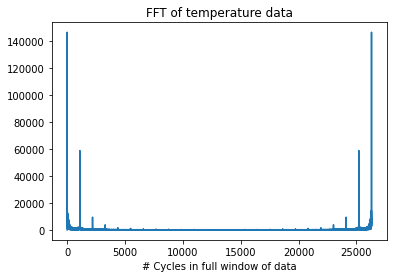

In [18]:
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt

season_df = df2.copy()
fft = fft((season_df.AirTemperature - season_df.AirTemperature.mean()).values)
plt.plot(np.abs(fft))
plt.title("FFT of temperature data")
plt.xlabel('# Cycles in full window of data');

Text(0.5, 0, 'Frequency ($y^{-1}$)')

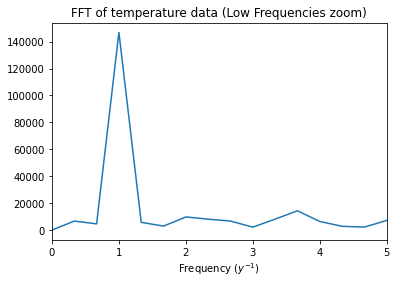

In [19]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)')

Text(0.5, 0, 'Frequency ($y^{-1}$)')

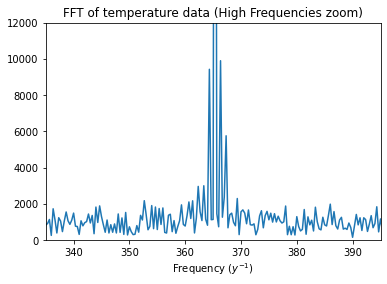

In [20]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (High Frequencies zoom)")
plt.ylim([0,12000])
plt.xlim([365-30, 365 + 30])
plt.xlabel('Frequency ($y^{-1}$)')

In [21]:
one_hot_df = pd.get_dummies(season_df, columns = ['Year','Quarter','Month','Hour'], drop_first=True)

In [22]:
one_hot_df.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2019-01-01 00:00:00,10.00000000,0.00000000,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,6.30000000,0.00000000,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,10.00000000,0.00000000,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,4.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 02:00:00,10.00000000,0.00000800,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,5.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 03:00:00,10.00000000,0.00000000,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,7.60000000,0.00000000,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 04:00:00,10.00000000,0.00000800,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,6.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,0


In [23]:
one_hot_df['Julian'] = pd.DatetimeIndex(one_hot_df['DateTime']).floor('d').to_julian_date()

In [24]:
one_hot_df.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Julian
0,2019-01-01 00:00:00,10.00000000,0.00000000,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,6.30000000,0.00000000,...,0,0,0,0,0,0,0,0,0,2458484.50000000
1,2019-01-01 01:00:00,10.00000000,0.00000000,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,4.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,2458484.50000000
2,2019-01-01 02:00:00,10.00000000,0.00000800,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,5.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,2458484.50000000
3,2019-01-01 03:00:00,10.00000000,0.00000000,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,7.60000000,0.00000000,...,0,0,0,0,0,0,0,0,0,2458484.50000000
4,2019-01-01 04:00:00,10.00000000,0.00000800,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,6.50000000,0.00000000,...,0,0,0,0,0,0,0,0,0,2458484.50000000


In [25]:
season_df['sin(year)'] = np.sin(one_hot_df['Julian'] / 365.25 * 2 * np.pi)
season_df['cos(year)'] = np.cos(one_hot_df['Julian'] / 365.25 * 2 * np.pi)
season_df['sin(6mo)'] = np.sin(one_hot_df['Julian'] / (365.25 / 2) * 2 * np.pi)
season_df['cos(6mo)'] = np.cos(one_hot_df['Julian'] / (365.25 / 2) * 2 * np.pi)
season_df['sin(day)'] = np.sin(one_hot_df.DateTime.dt.hour / 24.0 * 2* np.pi)
season_df['cos(day)'] = np.cos(one_hot_df.DateTime.dt.hour / 24.0 * 2* np.pi)
#regress = LinearRegression().fit(X=train[['sin(year)', 'cos(year)', 'sin(6mo)','cos(6mo)','sin(day)','cos(day)']], y=train['temp'])

### Increase December Month

In [26]:
december_df = season_df.query('20191201 <= DateTime < 20200101')
december_df2 = season_df.query('20201201 <= DateTime < 20210101')

In [27]:
all_decembers = pd.concat([december_df, december_df2])
all_decembers

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Azimuth,Elevation,SolarEvAngle,TheoreticalSolarRadiation,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day)
8016,2019-12-01 00:00:00,80.00000000,0.00000000,9.20000000,9.20000000,87.30000000,0.50000000,310.00000000,6.20000000,0.00000000,...,69.67000000,-54.72000000,-70.45584940,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.00000000,1.00000000
8017,2019-12-01 01:00:00,80.00000000,0.00000000,8.60000000,8.60000000,91.50000000,0.00000000,0.00000000,6.00000000,0.00000000,...,82.54000000,-43.57000000,-71.56967018,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.25881905,0.96592583
8018,2019-12-01 02:00:00,80.00000000,0.00000000,8.30000000,8.30000000,90.30000000,0.00000000,0.00000000,6.00000000,0.00000000,...,92.58000000,-32.11000000,-65.07239607,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.50000000,0.86602540
8019,2019-12-01 03:00:00,25.00000000,0.00000000,7.90000000,7.90000000,92.80000000,0.00000000,0.00000000,6.20000000,0.00000000,...,101.55000000,-20.73000000,-55.04817532,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.70710678,0.70710678
8020,2019-12-01 04:00:00,80.00000000,0.00000000,7.80000000,7.80000000,92.80000000,0.50000000,10.00000000,3.50000000,0.00000000,...,110.35000000,-9.72000000,-43.87049643,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.86602540,0.50000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2020-12-31 19:00:00,4.00000000,0.00401000,11.10000000,10.50000000,55.00000000,0.00000000,0.00000000,4.00000000,0.00000000,...,281.92000000,-50.13000000,-16.09600744,0.00000000,-0.23433389,0.97215617,-0.45561828,0.89017525,-0.96592583,0.25881905
17540,2020-12-31 20:00:00,4.00000000,0.00392300,10.50000000,10.00000000,58.10000000,0.00000000,0.00000000,4.00000000,0.00000000,...,297.20000000,-60.96000000,-27.31684836,0.00000000,-0.23433389,0.97215617,-0.45561828,0.89017525,-0.86602540,0.50000000
17541,2020-12-31 21:00:00,6.00000000,0.00392200,9.90000000,9.50000000,63.10000000,0.00000000,0.00000000,5.70000000,0.00000000,...,323.15000000,-69.83000000,-38.78483817,0.00000000,-0.23433389,0.97215617,-0.45561828,0.89017525,-0.70710678,0.70710678
17542,2020-12-31 22:00:00,6.00000000,0.00401000,9.40000000,9.00000000,66.20000000,0.00000000,0.00000000,5.50000000,0.00000000,...,6.33000000,-72.99000000,-50.20092977,0.00000000,-0.23433389,0.97215617,-0.45561828,0.89017525,-0.50000000,0.86602540


In [28]:
final_df = pd.concat([all_decembers, season_df])
final_df.reset_index(drop = True, inplace = True)
final_df

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Azimuth,Elevation,SolarEvAngle,TheoreticalSolarRadiation,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day)
0,2019-12-01 00:00:00,80.00000000,0.00000000,9.20000000,9.20000000,87.30000000,0.50000000,310.00000000,6.20000000,0.00000000,...,69.67000000,-54.72000000,-70.45584940,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.00000000,1.00000000
1,2019-12-01 01:00:00,80.00000000,0.00000000,8.60000000,8.60000000,91.50000000,0.00000000,0.00000000,6.00000000,0.00000000,...,82.54000000,-43.57000000,-71.56967018,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.25881905,0.96592583
2,2019-12-01 02:00:00,80.00000000,0.00000000,8.30000000,8.30000000,90.30000000,0.00000000,0.00000000,6.00000000,0.00000000,...,92.58000000,-32.11000000,-65.07239607,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.50000000,0.86602540
3,2019-12-01 03:00:00,25.00000000,0.00000000,7.90000000,7.90000000,92.80000000,0.00000000,0.00000000,6.20000000,0.00000000,...,101.55000000,-20.73000000,-55.04817532,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.70710678,0.70710678
4,2019-12-01 04:00:00,80.00000000,0.00000000,7.80000000,7.80000000,92.80000000,0.50000000,10.00000000,3.50000000,0.00000000,...,110.35000000,-9.72000000,-43.87049643,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.86602540,0.50000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27787,2021-12-31 19:00:00,6.00000000,0.00000000,8.90000000,8.40000000,62.00000000,0.00000000,0.00000000,1.50000000,0.00000000,...,281.92000000,-50.16000000,-16.22357409,0.00000000,-0.23851258,0.97113941,-0.46325792,0.88622350,-0.96592583,0.25881905
27788,2021-12-31 20:00:00,6.00000000,0.00000000,8.00000000,7.60000000,65.90000000,0.00000000,0.00000000,1.50000000,0.00000000,...,297.21000000,-60.99000000,-27.44443034,0.00000000,-0.23851258,0.97113941,-0.46325792,0.88622350,-0.86602540,0.50000000
27789,2021-12-31 21:00:00,6.00000000,0.00000000,7.30000000,6.90000000,70.10000000,0.00000000,0.00000000,1.50000000,0.00000000,...,323.19000000,-69.86000000,-38.91236736,0.00000000,-0.23851258,0.97113941,-0.46325792,0.88622350,-0.70710678,0.70710678
27790,2021-12-31 22:00:00,6.00000000,0.00000000,6.20000000,5.90000000,75.00000000,0.00000000,0.00000000,2.00000000,0.00000000,...,6.42000000,-73.01000000,-50.32853830,0.00000000,-0.23851258,0.97113941,-0.46325792,0.88622350,-0.50000000,0.86602540


In [29]:
final_df['Generation'].describe()

count   27792.00000000
mean       84.61693591
std       123.50292990
min         0.00000000
25%         0.00000000
50%         1.55303960
75%       154.69166860
max       456.31932180
Name: Generation, dtype: float64

In [30]:
final_df['Generation'].sort_values()

0         0.00000000
11516     0.00000000
11517     0.00000000
11519     0.00000000
11520     0.00000000
            ...     
22188   449.02139690
22164   450.60247290
22356   450.88633680
22141   455.27820460
22140   456.31932180
Name: Generation, Length: 27792, dtype: float64

### Cleaning Columns

In [31]:
final_df.columns

Index(['DateTime', 'WWCode', 'Generation', 'AirTemperature',
       'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection',
       'EffectiveCloudCover', 'ChangeOfSky', 'HazeDustSand', 'TornadoCloud',
       'Thunderstorm', 'Storm', 'Fog', 'Drizzle', 'Rain', 'SolidPre',
       'ShoweryPre', 'Month', 'Day', 'Year', 'Hour', 'DayOfYear', 'Quarter',
       'Day/Night', 'Azimuth', 'Elevation', 'SolarEvAngle',
       'TheoreticalSolarRadiation', 'sin(year)', 'cos(year)', 'sin(6mo)',
       'cos(6mo)', 'sin(day)', 'cos(day)'],
      dtype='object')

In [32]:
#Day, Month, Year, Hour, DayOfYear
clean_df = final_df.copy()
clean_df.drop(['Day', 'Month', 'Year', 'Hour', 'DayOfYear', 'Quarter'], axis=1, inplace=True)
clean_df.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Azimuth,Elevation,SolarEvAngle,TheoreticalSolarRadiation,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day)
0,2019-12-01 00:00:00,80.00000000,0.00000000,9.20000000,9.20000000,87.30000000,0.50000000,310.00000000,6.20000000,0.00000000,...,69.67000000,-54.72000000,-70.45584940,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.00000000,1.00000000
1,2019-12-01 01:00:00,80.00000000,0.00000000,8.60000000,8.60000000,91.50000000,0.00000000,0.00000000,6.00000000,0.00000000,...,82.54000000,-43.57000000,-71.56967018,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.25881905,0.96592583
2,2019-12-01 02:00:00,80.00000000,0.00000000,8.30000000,8.30000000,90.30000000,0.00000000,0.00000000,6.00000000,0.00000000,...,92.58000000,-32.11000000,-65.07239607,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.50000000,0.86602540
3,2019-12-01 03:00:00,25.00000000,0.00000000,7.90000000,7.90000000,92.80000000,0.00000000,0.00000000,6.20000000,0.00000000,...,101.55000000,-20.73000000,-55.04817532,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.70710678,0.70710678
4,2019-12-01 04:00:00,80.00000000,0.00000000,7.80000000,7.80000000,92.80000000,0.50000000,10.00000000,3.50000000,0.00000000,...,110.35000000,-9.72000000,-43.87049643,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.86602540,0.50000000


In [33]:
def zeroGeneration(df):
    df = df.assign(Zero=0)
    for i in range(len(df)):
        if df.loc[i, 'Generation'] < 0.1:
            df.iloc[i, 30] = 0
        else:
            df.iloc[i, 30] = 1
    return df

In [34]:
clean_df = zeroGeneration(clean_df)

In [35]:
clean_df.head(60)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Elevation,SolarEvAngle,TheoreticalSolarRadiation,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day),Zero
0,2019-12-01 00:00:00,80.00000000,0.00000000,9.20000000,9.20000000,87.30000000,0.50000000,310.00000000,6.20000000,0.00000000,...,-54.72000000,-70.45584940,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.00000000,1.00000000,0
1,2019-12-01 01:00:00,80.00000000,0.00000000,8.60000000,8.60000000,91.50000000,0.00000000,0.00000000,6.00000000,0.00000000,...,-43.57000000,-71.56967018,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.25881905,0.96592583,0
2,2019-12-01 02:00:00,80.00000000,0.00000000,8.30000000,8.30000000,90.30000000,0.00000000,0.00000000,6.00000000,0.00000000,...,-32.11000000,-65.07239607,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.50000000,0.86602540,0
3,2019-12-01 03:00:00,25.00000000,0.00000000,7.90000000,7.90000000,92.80000000,0.00000000,0.00000000,6.20000000,0.00000000,...,-20.73000000,-55.04817532,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.70710678,0.70710678,0
4,2019-12-01 04:00:00,80.00000000,0.00000000,7.80000000,7.80000000,92.80000000,0.50000000,10.00000000,3.50000000,0.00000000,...,-9.72000000,-43.87049643,0.00000000,-0.69290327,0.72103055,-0.99920886,0.03977011,0.86602540,0.50000000,0
5,2019-12-01 05:00:00,80.00000000,0.00000000,7.80000000,7.80000000,93.40000000,0.00000000,0.00000000,4.00000000,0.00000000,...,1.15000000,-32.38860644,11.82014999,-0.69290327,0.72103055,-0.99920886,0.03977011,0.96592583,0.25881905,0
6,2019-12-01 06:00:00,80.00000000,0.00000000,8.60000000,7.50000000,87.90000000,2.60000000,230.00000000,6.60000000,0.00000000,...,10.29000000,-20.99234492,148.86639304,-0.69290327,0.72103055,-0.99920886,0.03977011,1.00000000,0.00000000,0
7,2019-12-01 07:00:00,25.00000000,0.55623900,7.60000000,7.60000000,93.40000000,0.50000000,170.00000000,5.00000000,0.00000000,...,18.27000000,-9.95497747,313.36649495,-0.69290327,0.72103055,-0.99920886,0.03977011,0.96592583,-0.25881905,1
8,2019-12-01 08:00:00,80.00000000,4.38872350,7.80000000,7.70000000,90.20000000,1.00000000,240.00000000,5.00000000,0.00000000,...,24.28000000,0.44779158,444.37504685,-0.69290327,0.72103055,-0.99920886,0.03977011,0.86602540,-0.50000000,1
9,2019-12-01 09:00:00,80.00000000,14.62754050,7.70000000,7.60000000,90.20000000,0.50000000,280.00000000,7.00000000,0.00000000,...,27.71000000,9.87573994,519.51455395,-0.69290327,0.72103055,-0.99920886,0.03977011,0.70710678,-0.70710678,1


In [36]:
clean_df.dtypes

DateTime                     datetime64[ns]
WWCode                              float64
Generation                          float64
AirTemperature                      float64
ComfortTemperature                  float64
RelativeHumidity                    float64
WindSpeed                           float64
WindDirection                       float64
EffectiveCloudCover                 float64
ChangeOfSky                         float64
HazeDustSand                        float64
TornadoCloud                        float64
Thunderstorm                        float64
Storm                               float64
Fog                                 float64
Drizzle                             float64
Rain                                float64
SolidPre                            float64
ShoweryPre                          float64
Day/Night                             int64
Azimuth                             float64
Elevation                           float64
SolarEvAngle                    

### Prep Data For Modelling

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [38]:
clean_df.shape

(27792, 31)

In [39]:
df_new = clean_df.copy()
#df_train = df_train.drop(df.index[25560:], axis=0)
df_train = df_new.drop(df_new.index[27048:], axis=0)

#df_test = clean_df.iloc[25560:26304] # dates between 2021-12-1 and 2021-12-31
df_test = clean_df.iloc[27048:] # dates between 2021-12-1 and 2021-12-31

df_test.reset_index(drop=True, inplace=True)
df_test.head(5)

,DateTime,WWCode,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,ChangeOfSky,...,Elevation,SolarEvAngle,TheoreticalSolarRadiation,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day),Zero
0,2021-12-01 00:00:00,60.00000000,0.00000000,4.90000000,4.70000000,86.90000000,1.00000000,210.00000000,7.30000000,0.00000000,...,-54.80000000,-70.45584940,0.00000000,-0.68667598,0.72696362,-0.99837691,0.05695220,0.00000000,1.00000000,0
1,2021-12-01 01:00:00,61.00000000,0.00000000,4.90000000,4.70000000,86.90000000,0.50000000,210.00000000,6.00000000,0.00000000,...,-43.65000000,-71.56967018,0.00000000,-0.68667598,0.72696362,-0.99837691,0.05695220,0.25881905,0.96592583,0
2,2021-12-01 02:00:00,61.00000000,0.00000000,4.50000000,4.30000000,84.40000000,1.00000000,210.00000000,6.00000000,0.00000000,...,-32.19000000,-65.07239607,0.00000000,-0.68667598,0.72696362,-0.99837691,0.05695220,0.50000000,0.86602540,0
3,2021-12-01 03:00:00,21.00000000,0.00000000,3.70000000,3.50000000,86.80000000,1.50000000,200.00000000,7.30000000,0.00000000,...,-20.81000000,-55.04817532,0.00000000,-0.68667598,0.72696362,-0.99837691,0.05695220,0.70710678,0.70710678,0
4,2021-12-01 04:00:00,68.00000000,0.00000000,3.70000000,3.50000000,86.80000000,1.00000000,210.00000000,6.50000000,0.00000000,...,-9.81000000,-43.87049643,0.00000000,-0.68667598,0.72696362,-0.99837691,0.05695220,0.86602540,0.50000000,0


In [40]:
df_test.shape

(744, 31)

In [41]:
df_train.shape

(27048, 31)

### Standardization / Normalization

In [42]:
from sklearn.preprocessing import MinMaxScaler

def min_max(df):
    df = MinMaxScaler().fit_transform(df) # normalizing the features
    normalised_df = pd.DataFrame(df)
    return normalised_df

### Train a Model

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snsmake_column_transformer
import seaborn as sns
sns.set_theme()

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [44]:
def split_train(df, split_date):
    train = df.loc[df.DateTime <= split_date].copy()
    val = df.loc[df.DateTime > split_date].copy()
    return train, val

In [45]:
######
split_date = '2021-05-01'
df_train, df_val = split_train(df_train, split_date)

In [46]:
########
x_train = df_train.loc[:, df_train.columns != 'Generation']
y_train = df_train['Generation']
x_val = df_val.loc[:, df_val.columns != 'Generation']
y_val = df_val['Generation']

In [47]:
from sklearn.model_selection import train_test_split
X = df_train.loc[:, df_train.columns != 'Generation']
y = df_train['Generation']


x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=df_train['Zero'], 
                                                    test_size=0.25)

In [48]:
x_test = df_test.copy()
x_train.drop(['DateTime', 'Zero'], axis=1, inplace=True)
x_val.drop(['DateTime', 'Zero'], axis=1, inplace=True)
x_test.drop(['DateTime', 'Zero', 'Generation'], axis=1, inplace=True)

In [49]:
#x_train=min_max(x_train)
#x_val=min_max(x_val)
#x_test=min_max(x_test)

In [50]:
datasets = {'x_train': x_train,
            'y_train': y_train,
            'x_val': x_val,
            'y_val': y_val,
            'x_test': x_test
            }

In [51]:
def pred_model(model, **datasets):
    pred_val = model.predict(datasets['x_val'])
    pred_val = pd.DataFrame(pred_val, index=datasets['x_val'].index, columns=['pred'])
    
    pred_test = model.predict(datasets['x_test'])

    return pred_test, pred_val

### FLAML

In [52]:
automl = AutoML()
settings = {
    "time_budget": 300,  
    "metric": 'rmse',
    "estimator_list": ['lgbm'],
    "task": 'regression',
}
automl.fit(X_train=datasets['x_train'], y_train=datasets['y_train'], **settings)

[flaml.automl: 03-02 22:11:01] {2055} INFO - task = regression
[flaml.automl: 03-02 22:11:01] {2057} INFO - Data split method: uniform
[flaml.automl: 03-02 22:11:01] {2061} INFO - Evaluation method: cv
[flaml.automl: 03-02 22:11:01] {2142} INFO - Minimizing error metric: rmse
[flaml.automl: 03-02 22:11:01] {2200} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 03-02 22:11:01] {2453} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-02 22:11:01] {2569} INFO - Estimated sufficient time budget=3136s. Estimated necessary time budget=3s.
[flaml.automl: 03-02 22:11:01] {2621} INFO -  at 0.4s,	estimator lgbm's best error=85.8190,	best estimator lgbm's best error=85.8190
[flaml.automl: 03-02 22:11:01] {2453} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-02 22:11:02] {2621} INFO -  at 0.7s,	estimator lgbm's best error=85.8190,	best estimator lgbm's best error=85.8190
[flaml.automl: 03-02 22:11:02] {2453} INFO - iteration 2, current learner lgbm
[flaml.aut

In [53]:
model = LGBMRegressor(**automl.best_config)    
model.fit(datasets['x_train'], datasets['y_train'])

LGBMRegressor(colsample_bytree=0.521249275563306,
              learning_rate=0.07484328408686308, log_max_bin=10,
              min_child_samples=9, n_estimators=943, num_leaves=27,
              reg_alpha=0.004879201633757342, reg_lambda=0.047191432747920446)

In [54]:
x_train.dtypes

WWCode                       float64
AirTemperature               float64
ComfortTemperature           float64
RelativeHumidity             float64
WindSpeed                    float64
WindDirection                float64
EffectiveCloudCover          float64
ChangeOfSky                  float64
HazeDustSand                 float64
TornadoCloud                 float64
Thunderstorm                 float64
Storm                        float64
Fog                          float64
Drizzle                      float64
Rain                         float64
SolidPre                     float64
ShoweryPre                   float64
Day/Night                      int64
Azimuth                      float64
Elevation                    float64
SolarEvAngle                 float64
TheoreticalSolarRadiation    float64
sin(year)                    float64
cos(year)                    float64
sin(6mo)                     float64
cos(6mo)                     float64
sin(day)                     float64
c

In [55]:
pred_flaml, pred_val_flaml = pred_model(model, **datasets)

### Optuna

In [56]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 500)
    n_estimators = trial.suggest_int("n_estimators", 0, 10000)
    
    model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(
        datasets['x_train'],
        datasets['y_train'],
        early_stopping_rounds=early_stopping_rounds,
        eval_set=[(datasets['x_val'], datasets['y_val'])],
        verbose=1000,
    )
    preds_valid = model.predict(datasets['x_val'])
    rmse = mean_squared_error(datasets['y_val'], preds_valid, squared=False)

    return rmse

In [57]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2022-03-02 22:15:59,172] A new study created in memory with name: no-name-26682dd4-5e08-41bf-8637-e12667e636e7


[0]	validation_0-rmse:139.70155
[1000]	validation_0-rmse:20.57291
[2000]	validation_0-rmse:19.89035
[3000]	validation_0-rmse:19.59880
[4000]	validation_0-rmse:19.41572
[5000]	validation_0-rmse:19.28549
[6000]	validation_0-rmse:19.19951
[7000]	validation_0-rmse:19.12231
[8000]	validation_0-rmse:19.07789
[9000]	validation_0-rmse:19.03708
[9063]	validation_0-rmse:19.03486


[I 2022-03-02 22:17:00,402] Trial 0 finished with value: 19.034816184058958 and parameters: {'learning_rate': 0.017064708757835407, 'reg_lambda': 3.756507588287015, 'reg_alpha': 3.335540164510408e-07, 'subsample': 0.22198039537356995, 'colsample_bytree': 0.917362778321254, 'max_depth': 7, 'early_stopping_rounds': 143, 'n_estimators': 9064}. Best is trial 0 with value: 19.034816184058958.


[0]	validation_0-rmse:139.39198
[1000]	validation_0-rmse:23.13743
[1148]	validation_0-rmse:22.93926


[I 2022-03-02 22:17:02,308] Trial 1 finished with value: 22.938001730638796 and parameters: {'learning_rate': 0.01945908118770806, 'reg_lambda': 3.3073902340716788, 'reg_alpha': 13.828549835907467, 'subsample': 0.7611195203814091, 'colsample_bytree': 0.9481993383953119, 'max_depth': 3, 'early_stopping_rounds': 197, 'n_estimators': 1149}. Best is trial 0 with value: 19.034816184058958.


[0]	validation_0-rmse:136.08276
[1000]	validation_0-rmse:19.60687
[2000]	validation_0-rmse:18.80019
[3000]	validation_0-rmse:18.41580
[4000]	validation_0-rmse:18.26257
[5000]	validation_0-rmse:18.16430
[6000]	validation_0-rmse:18.11292
[7000]	validation_0-rmse:18.07585
[8000]	validation_0-rmse:18.05203
[8184]	validation_0-rmse:18.04902


[I 2022-03-02 22:17:24,773] Trial 2 finished with value: 18.049021066522222 and parameters: {'learning_rate': 0.04310324859591285, 'reg_lambda': 0.0011173085543193125, 'reg_alpha': 2.5992469588522497e-05, 'subsample': 0.9206666765806599, 'colsample_bytree': 0.9422814589002819, 'max_depth': 5, 'early_stopping_rounds': 226, 'n_estimators': 8185}. Best is trial 2 with value: 18.049021066522222.


[0]	validation_0-rmse:110.86700
[1000]	validation_0-rmse:21.44525
[2000]	validation_0-rmse:20.86305
[3000]	validation_0-rmse:20.62743
[4000]	validation_0-rmse:20.44689
[5000]	validation_0-rmse:20.38067
[6000]	validation_0-rmse:20.33668
[7000]	validation_0-rmse:20.27444
[7700]	validation_0-rmse:20.25717


[I 2022-03-02 22:17:36,020] Trial 3 finished with value: 20.253725307711814 and parameters: {'learning_rate': 0.24416977243136484, 'reg_lambda': 0.00010236946350801583, 'reg_alpha': 8.441798647686119e-07, 'subsample': 0.7904180834749699, 'colsample_bytree': 0.6321655536023362, 'max_depth': 3, 'early_stopping_rounds': 384, 'n_estimators': 9524}. Best is trial 2 with value: 18.049021066522222.


[0]	validation_0-rmse:130.92854
[1000]	validation_0-rmse:18.34169
[2000]	validation_0-rmse:17.99098
[3000]	validation_0-rmse:17.92828
[4000]	validation_0-rmse:17.91357
[5000]	validation_0-rmse:17.90614
[6000]	validation_0-rmse:17.90275
[7000]	validation_0-rmse:17.90067
[7693]	validation_0-rmse:17.89971


[I 2022-03-02 22:18:09,001] Trial 4 finished with value: 17.899706666704862 and parameters: {'learning_rate': 0.08120838092979442, 'reg_lambda': 0.15697895447376992, 'reg_alpha': 2.807539292001821, 'subsample': 0.9785839142102721, 'colsample_bytree': 0.6046404085003593, 'max_depth': 6, 'early_stopping_rounds': 211, 'n_estimators': 7694}. Best is trial 4 with value: 17.899706666704862.


[0]	validation_0-rmse:131.76068
[703]	validation_0-rmse:24.46809


[I 2022-03-02 22:18:09,994] Trial 5 finished with value: 24.468092720749855 and parameters: {'learning_rate': 0.08261564647485856, 'reg_lambda': 0.009257063906113234, 'reg_alpha': 6.134729136925291, 'subsample': 0.6905103029962478, 'colsample_bytree': 0.33766930576595755, 'max_depth': 2, 'early_stopping_rounds': 432, 'n_estimators': 704}. Best is trial 4 with value: 17.899706666704862.


[0]	validation_0-rmse:139.30165
[1000]	validation_0-rmse:39.03267
[1269]	validation_0-rmse:38.90460


[I 2022-03-02 22:18:11,304] Trial 6 finished with value: 38.90460232801887 and parameters: {'learning_rate': 0.02375373494165073, 'reg_lambda': 1.4165677336903701, 'reg_alpha': 5.6988433827346025e-06, 'subsample': 0.6536158726080998, 'colsample_bytree': 0.9905016030198219, 'max_depth': 1, 'early_stopping_rounds': 282, 'n_estimators': 1270}. Best is trial 4 with value: 17.899706666704862.


[0]	validation_0-rmse:133.74068
[1000]	validation_0-rmse:22.16335
[2000]	validation_0-rmse:21.66810
[3000]	validation_0-rmse:21.16023
[3032]	validation_0-rmse:21.15857


[I 2022-03-02 22:18:15,346] Trial 7 finished with value: 21.153170058662955 and parameters: {'learning_rate': 0.06278159694640918, 'reg_lambda': 0.00019370428689012667, 'reg_alpha': 0.2084690122508336, 'subsample': 0.33662354458807237, 'colsample_bytree': 0.654640662889991, 'max_depth': 3, 'early_stopping_rounds': 211, 'n_estimators': 3033}. Best is trial 4 with value: 17.899706666704862.


[0]	validation_0-rmse:128.98044
[728]	validation_0-rmse:22.55079


[I 2022-03-02 22:18:16,321] Trial 8 finished with value: 22.54709815031914 and parameters: {'learning_rate': 0.1409243470242959, 'reg_lambda': 6.187418113055781e-06, 'reg_alpha': 0.05961944266055996, 'subsample': 0.6415954783517479, 'colsample_bytree': 0.2471862285970541, 'max_depth': 3, 'early_stopping_rounds': 143, 'n_estimators': 729}. Best is trial 4 with value: 17.899706666704862.


[0]	validation_0-rmse:127.84637
[1000]	validation_0-rmse:24.04153
[2000]	validation_0-rmse:23.63127
[2357]	validation_0-rmse:23.69424


[I 2022-03-02 22:18:18,916] Trial 9 finished with value: 23.62755004292028 and parameters: {'learning_rate': 0.11395984489495402, 'reg_lambda': 3.284040963705716e-05, 'reg_alpha': 0.005013681471959168, 'subsample': 0.1789460634543203, 'colsample_bytree': 0.9847930604483742, 'max_depth': 2, 'early_stopping_rounds': 393, 'n_estimators': 4906}. Best is trial 4 with value: 17.899706666704862.


In [58]:
optuna_params = study.best_params
optuna_params

{'learning_rate': 0.08120838092979442,
 'reg_lambda': 0.15697895447376992,
 'reg_alpha': 2.807539292001821,
 'subsample': 0.9785839142102721,
 'colsample_bytree': 0.6046404085003593,
 'max_depth': 6,
 'early_stopping_rounds': 211,
 'n_estimators': 7694}

In [59]:
model = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    **optuna_params
)
model.fit(
    datasets['x_train'],
    datasets['y_train'],
    early_stopping_rounds=optuna_params['early_stopping_rounds'],
    eval_set=[(datasets['x_val'], datasets['y_val'])],
    verbose=1000,
)

[22:18:19] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:130.92854
[1000]	validation_0-rmse:18.34169
[2000]	validation_0-rmse:17.99098
[3000]	validation_0-rmse:17.92828
[4000]	validation_0-rmse:17.91357
[5000]	validation_0-rmse:17.90614
[6000]	validation_0-rmse:17.90275
[7000]	validation_0-rmse:17.90067
[7693]	validation_0-rmse:17.89971


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6046404085003593,
             early_stopping_rounds=211, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08120838092979442, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=7694, n_jobs=2, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=42,
             reg_alpha=2.807539292001821, reg_lambda=0.15697895447376992,
             scale_pos_weight=1, subsample=0.9785839142102721,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [60]:
pred_optuna, pred_val_optuna = pred_model(model, **datasets)

In [61]:
def clip_nights(pred, test = False):
    nights = [21, 22, 23, 0, 1, 2, 3, 4]
    if not test:
        for time, row in pred.iterrows():
            if time in nights or row['pred'] < 0: # .hour sildim
                row['pred'] = 0
        return pred
    else:
        for i, hour in enumerate(pd.to_datetime(pred['DateTime'])):
            if hour.hour in nights or pred.loc[i, 'Generation'] < 0:
                pred.loc[i, 'Generation'] = 0
        return pred

In [62]:
pred_val_flaml = clip_nights(pred_val_flaml)
#pred_optuna = clip_nights(pred_optuna)

In [63]:
rmse_flaml = mean_squared_error(datasets['y_val'], pred_val_flaml, squared=False)
#rmse_optuna = mean_squared_error(datasets['y_val'], pred_val_optuna, squared=False)
print('Flaml RMSE: ', rmse_flaml)
#print('Optuna RMSE: ', rmse_optuna)

Flaml RMSE:  18.41632761355881


In [64]:
pred_flaml = np.clip(pred_flaml, a_min=0, a_max=500)

In [65]:
submission2 = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission2['Generation'] = pred_flaml
submission2.to_csv('submission56.csv', index=False)

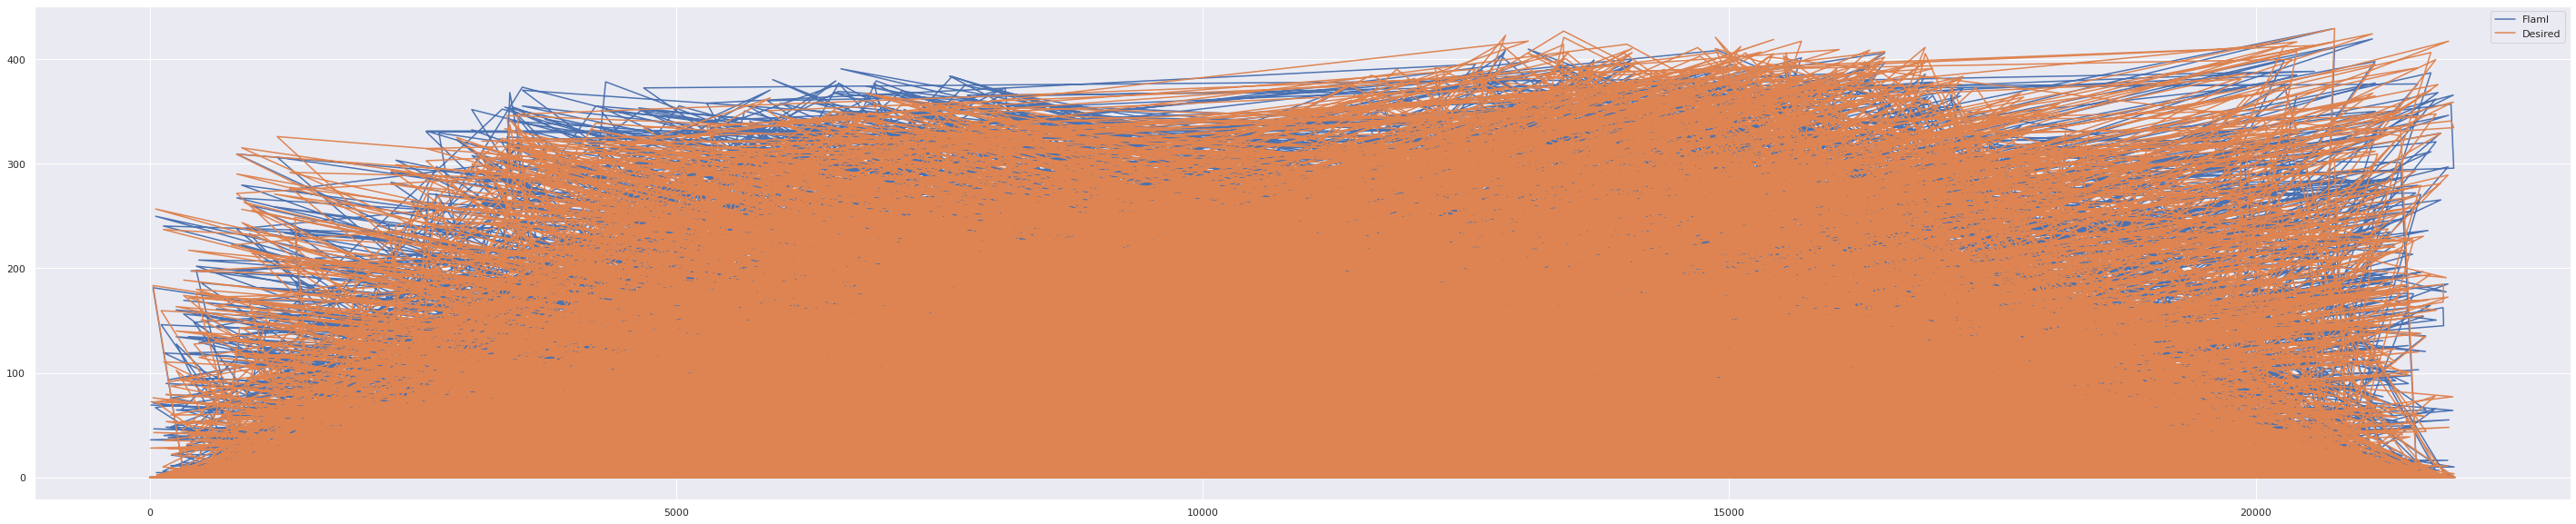

In [66]:
plt.figure(figsize=(50,10))
plt.plot(pred_val_flaml)
#plt.plot(pred_val_optuna)
plt.plot(y_val)
plt.legend(['Flaml', 'Desired'])
plt.show()

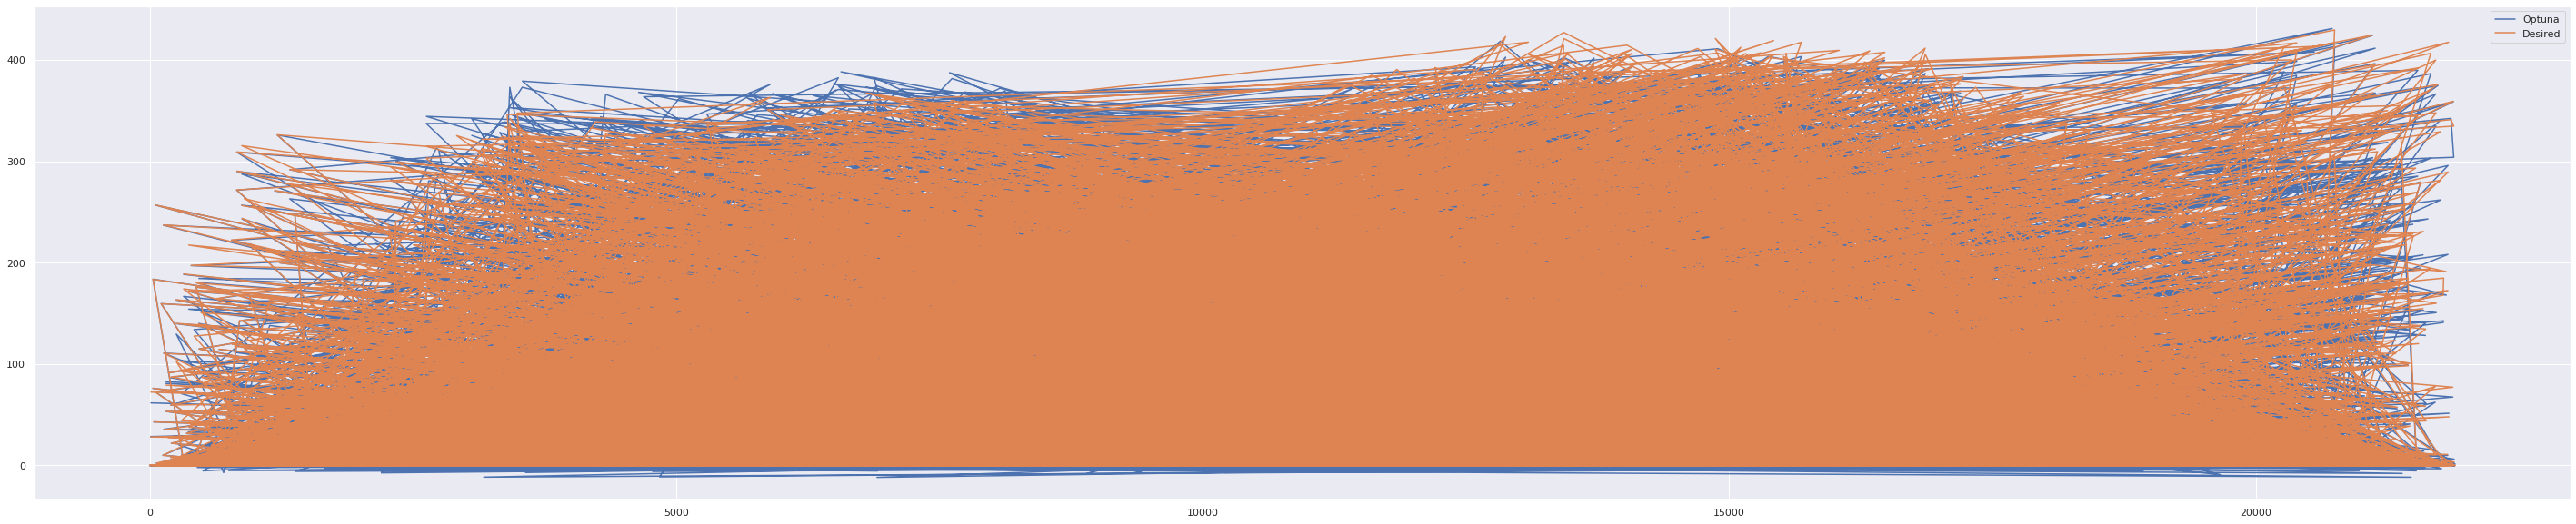

In [67]:
plt.figure(figsize=(50,10))
#plt.plot(pred_val_flaml)
plt.plot(pred_val_optuna)
plt.plot(y_val)
plt.legend(['Optuna', 'Desired'])
plt.show()

In [68]:
submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission['Generation'] = pred_flaml

submission2 = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission2['Generation'] = pred_optuna

In [69]:
submission = clip_nights(submission, test=True)
submission2 = clip_nights(submission2, test=True)

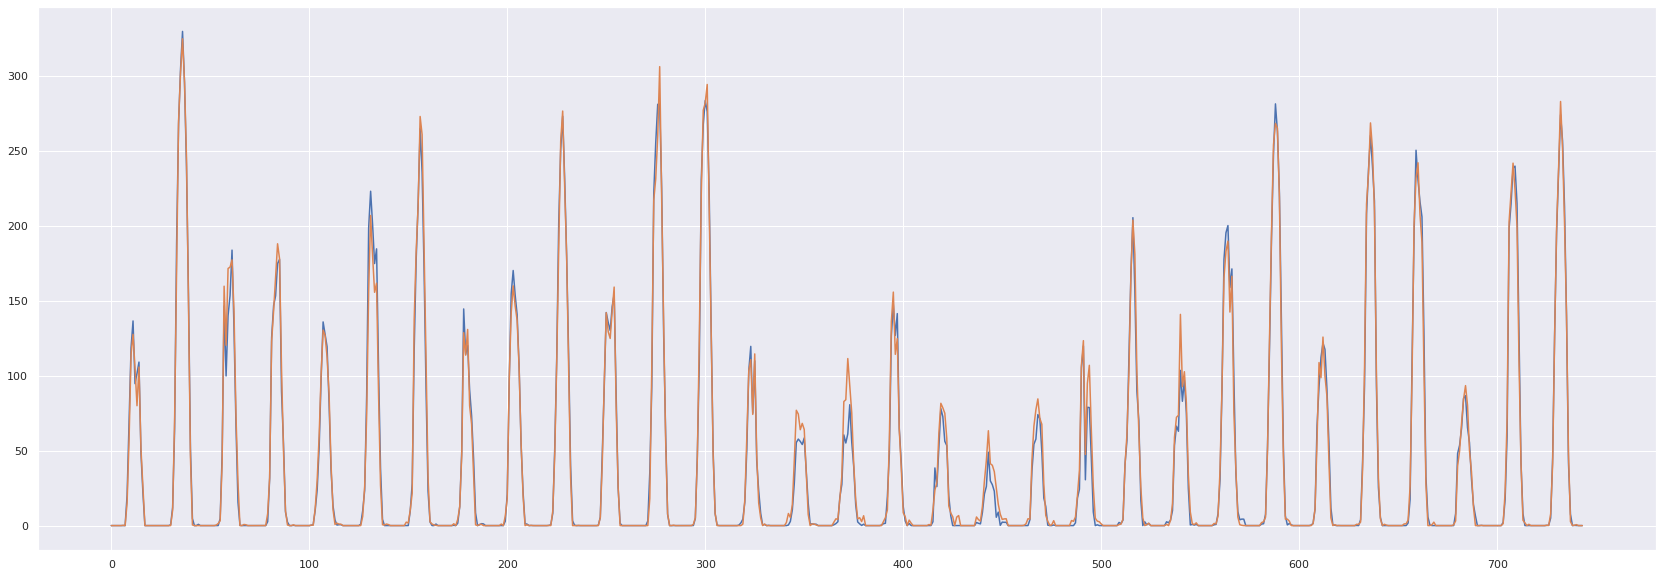

In [70]:
plt.figure(figsize=(29,10))
plt.plot(submission['Generation'])
plt.plot(submission2['Generation'])
plt.show()

In [71]:
submission.to_csv('submission.csv', index=False)
submission2.to_csv('submission2.csv', index=False)